In [6]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

# Шляхи до датасету
dataset_path = "../data/precessed/png_images/"
train_output_path = "../data/tfrec/train/"  # Шлях для збереження тренувальних TFRecord файлів
val_output_path = "../data/tfrec/val/"  # Шлях для збереження валідаційних TFRecord файлів
os.makedirs(train_output_path, exist_ok=True)
os.makedirs(val_output_path, exist_ok=True)

# Функція для перетворення зображення в байтовий формат
def image_to_tfexample(image, label, num_classes):
    image_data = tf.io.encode_jpeg(image).numpy()  # Зберігаємо зображення як JPEG
    label_onehot = tf.one_hot(label, depth=num_classes).numpy().tolist()
    return tf.train.Example(features=tf.train.Features(feature={
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_data])),
        'label': tf.train.Feature(float_list=tf.train.FloatList(value=label_onehot))
    }))

# Функція для аугментації зображення
def augment_image(image):
    image = tf.image.random_flip_left_right(image)  # Випадкове віддзеркалення
    image = tf.image.random_brightness(image, max_delta=0.1)  # Випадкова зміна яскравості
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Випадкова зміна контрасту
    return image

# Функція для створення TFRecord файлів
def create_tfrecord_onehot(dataset_path, train_output_path, val_output_path, num_classes, val_split=0.2, num_shards=10):
    class_names = sorted(os.listdir(dataset_path))  # Отримуємо список класів
    all_image_paths = []
    all_labels = []

    # Збираємо всі зображення та мітки
    for class_id, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_path, class_name)
        image_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith('.png')]
        all_image_paths.extend(image_files)
        all_labels.extend([class_id] * len(image_files))

    # Перемішуємо дані
    combined = list(zip(all_image_paths, all_labels))
    random.shuffle(combined)
    all_image_paths, all_labels = zip(*combined)

    # Розділяємо на тренувальний та валідаційний набори
    train_files, val_files, train_labels, val_labels = train_test_split(
        all_image_paths, all_labels, test_size=val_split, random_state=42
    )

    # Записуємо тренувальні зображення в TFRecord
    for shard_id in range(num_shards):
        train_output_file = os.path.join(train_output_path, f"train_shard_{shard_id}.tfrecord")
        with tf.io.TFRecordWriter(train_output_file) as writer:
            for i, (image_path, label) in enumerate(zip(train_files, train_labels)):
                if i % num_shards == shard_id:  # Розподіляємо зображення між шардами
                    image = tf.io.decode_image(tf.io.read_file(image_path), channels=3)
                    image = tf.image.resize(image, [224, 224])  # Змінюємо розмір зображення
                    image = augment_image(image)  # Застосовуємо аугментацію
                    image = tf.cast(image, tf.uint8)  # Конвертуємо в uint8 для збереження
                    example = image_to_tfexample(image, label, num_classes)
                    writer.write(example.SerializeToString())
            print(f"Train shard {shard_id} written to {train_output_file}")

    # Записуємо валідаційні зображення в TFRecord
    val_output_file = os.path.join(val_output_path, "val_data.tfrecord")
    with tf.io.TFRecordWriter(val_output_file) as writer:
        for image_path, label in zip(val_files, val_labels):
            image = tf.io.decode_image(tf.io.read_file(image_path), channels=3)
            image = tf.image.resize(image, [224, 224])  # Змінюємо розмір зображення
            image = tf.cast(image, tf.uint8)  # Конвертуємо в uint8 для збереження
            example = image_to_tfexample(image, label, num_classes)
            writer.write(example.SerializeToString())
        print(f"Validation data written to {val_output_file}")

# Кількість класів
num_classes = 250  # Заміни на кількість класів у твоєму датасеті

# Створюємо TFRecord файли з перемішуванням та аугментацією
create_tfrecord_onehot(dataset_path, train_output_path, val_output_path, num_classes, val_split=0.2)

Train shard 0 written to ../data/tfrec/train/train_shard_0.tfrecord
Train shard 1 written to ../data/tfrec/train/train_shard_1.tfrecord
Train shard 2 written to ../data/tfrec/train/train_shard_2.tfrecord
Train shard 3 written to ../data/tfrec/train/train_shard_3.tfrecord
Train shard 4 written to ../data/tfrec/train/train_shard_4.tfrecord
Train shard 5 written to ../data/tfrec/train/train_shard_5.tfrecord
Train shard 6 written to ../data/tfrec/train/train_shard_6.tfrecord
Train shard 7 written to ../data/tfrec/train/train_shard_7.tfrecord
Train shard 8 written to ../data/tfrec/train/train_shard_8.tfrecord
Train shard 9 written to ../data/tfrec/train/train_shard_9.tfrecord
Validation data written to ../data/tfrec/val/val_data.tfrecord


Images shape: (32, 224, 224, 3)
Labels shape: (32, 250)


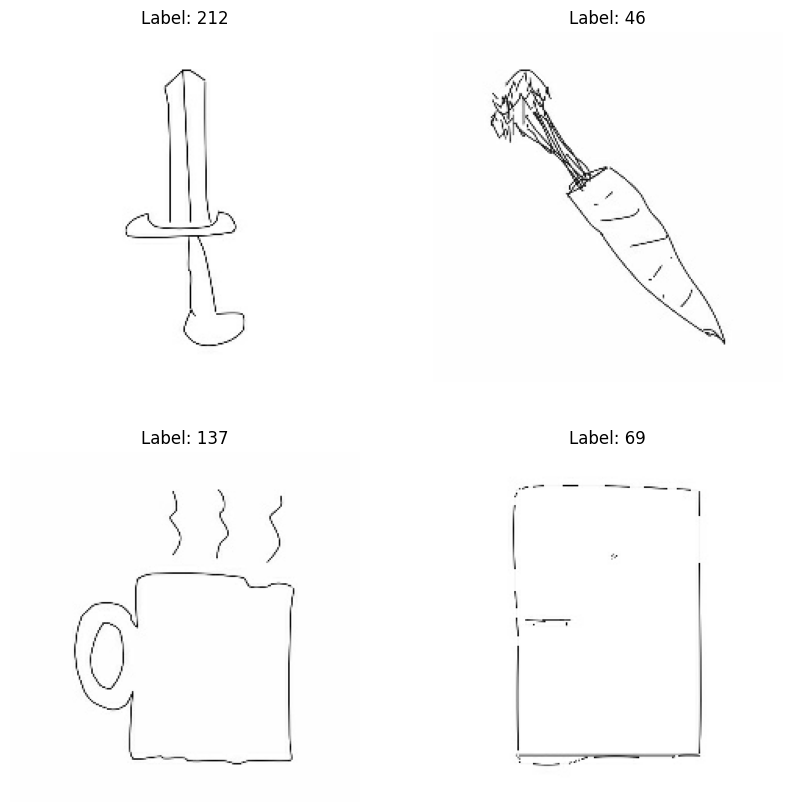

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Функція для парсингу TFRecord
def parse_tfrecord_onehot(example_proto, num_classes):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([num_classes], tf.float32),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_jpeg(example['image'], channels=3)  # Декодуємо JPEG
    image = tf.image.convert_image_dtype(image, tf.float32)  # Конвертуємо в float32
    label = example['label']
    return image, label

# Завантажуємо TFRecord файли
def load_tfrecord_onehot_dataset(tfrecord_files, num_classes, batch_size=32):
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(lambda x: parse_tfrecord_onehot(x, num_classes), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Завантажуємо тренувальний датасет
train_tfrecord_files = [os.path.join(train_output_path, f) for f in os.listdir(train_output_path) if f.endswith('.tfrecord')]
val_tfrecord_files = [os.path.join(val_output_path, f) for f in os.listdir(val_output_path) if f.endswith('.tfrecord')]

train_dataset = load_tfrecord_onehot_dataset(train_tfrecord_files, num_classes, batch_size=32)
val_dataset = load_tfrecord_onehot_dataset(val_tfrecord_files, num_classes, batch_size=32)

# Приклад використання датасету
for images, labels in train_dataset.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

# Візуалізація зображень
def visualize_images(dataset, num_images=4, is_onehot=False):
    for images, labels in dataset.take(1):  # Беремо один батч даних
        images = images.numpy()  # Конвертуємо тензори в NumPy
        labels = labels.numpy()
        
        plt.figure(figsize=(10, 10))
        for i in range(min(num_images, len(images))):  # Візуалізуємо до num_images зображень
            plt.subplot(2, 2, i + 1)
            plt.imshow(images[i])  # Відображаємо зображення
            
            # Обробка міток
            if is_onehot:
                # Якщо мітки у форматі one-hot encoding, перетворюємо їх у цілі числа
                label = np.argmax(labels[i])
            else:
                # Якщо мітки вже у форматі цілих чисел
                label = labels[i]
            
            plt.title(f"Label: {label}")  # Показуємо мітку
            plt.axis('off')
        plt.show()

# Виводимо зображення
visualize_images(train_dataset, is_onehot=True)  # Встанови is_onehot=True, якщо мітки у форматі one-hot encoding